In [30]:
import os
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


import opensmile

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle

from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [31]:
DATA_PATH = "../data/raw/"

**FEATURES**

* **emobase** feature-set:
    - 26 LLDs: F0, 12 MFCCs, ZCR, Probability of Voicing, Inesity, Loudness, Envelope, 8 Line Spectral Frequencies
    - Delta coeficients
    - 19 statistical functionals: Mean, Std, Min, Max, Skewness, Kurtosis, Range, Slope, Offset, MSE, 3 Inter-Quartile ranges, Quartile 1-3
- Total 988 features

In [38]:
# Defining opensmile feature-set
smile = opensmile.Smile(
    feature_set=opensmile.FeatureSet.emobase,
    feature_level=opensmile.FeatureLevel.Functionals,
)
print(f" There are {len(smile.feature_names)} features.")

 There are 988 features.


In [4]:
smile.feature_names

['pcm_intensity_sma_max',
 'pcm_intensity_sma_min',
 'pcm_intensity_sma_range',
 'pcm_intensity_sma_maxPos',
 'pcm_intensity_sma_minPos',
 'pcm_intensity_sma_amean',
 'pcm_intensity_sma_linregc1',
 'pcm_intensity_sma_linregc2',
 'pcm_intensity_sma_linregerrA',
 'pcm_intensity_sma_linregerrQ',
 'pcm_intensity_sma_stddev',
 'pcm_intensity_sma_skewness',
 'pcm_intensity_sma_kurtosis',
 'pcm_intensity_sma_quartile1',
 'pcm_intensity_sma_quartile2',
 'pcm_intensity_sma_quartile3',
 'pcm_intensity_sma_iqr1-2',
 'pcm_intensity_sma_iqr2-3',
 'pcm_intensity_sma_iqr1-3',
 'pcm_loudness_sma_max',
 'pcm_loudness_sma_min',
 'pcm_loudness_sma_range',
 'pcm_loudness_sma_maxPos',
 'pcm_loudness_sma_minPos',
 'pcm_loudness_sma_amean',
 'pcm_loudness_sma_linregc1',
 'pcm_loudness_sma_linregc2',
 'pcm_loudness_sma_linregerrA',
 'pcm_loudness_sma_linregerrQ',
 'pcm_loudness_sma_stddev',
 'pcm_loudness_sma_skewness',
 'pcm_loudness_sma_kurtosis',
 'pcm_loudness_sma_quartile1',
 'pcm_loudness_sma_quartile2'

**FEATURE EXTRACTION**

In [5]:
def process_audio_file(file_path, speaker_id, emotion, smile):
    audio, sr = librosa.load(file_path)
    
    if len(audio) == 0:
        return np.array([np.nan for _ in range(len(smile.column_names) + 2)])

    feature_vector = smile.process_file(file_path).to_numpy()[0]
    
    return np.concatenate((feature_vector, np.array([speaker_id, emotion])))

In [6]:
DATA_PATH = "../data/raw/"

smile_columns = list(smile.column_names)
smile_columns.extend(["speaker_id", "target"])

speakers = os.listdir(DATA_PATH)

In [7]:
data = {}

for sc in smile_columns:
    data[sc] = []

for speaker_id, speaker_name in enumerate(speakers):
    speaker_path = os.path.join(DATA_PATH, speaker_name)
    
    if len(os.listdir(speaker_path)) != 5:
        continue

    for emotion in range(5):
        audio_files = os.listdir(os.path.join(speaker_path, f"{emotion}"))
        for af in audio_files:
            file_path = os.path.join(speaker_path, f"{emotion}", af)
            row = process_audio_file(file_path, speaker_id, emotion, smile)
            
            if len(row) == 0:
                continue
                
            if np.isnan(row).any():
                continue
            
            for value, label in zip(row, smile_columns):
                data[label].append(value)
                
df = pd.DataFrame(data)

In [8]:
df.head()

,pcm_intensity_sma_max,pcm_intensity_sma_min,pcm_intensity_sma_range,pcm_intensity_sma_maxPos,pcm_intensity_sma_minPos,pcm_intensity_sma_amean,pcm_intensity_sma_linregc1,pcm_intensity_sma_linregc2,pcm_intensity_sma_linregerrA,pcm_intensity_sma_linregerrQ,...,F0env_sma_de_skewness,F0env_sma_de_kurtosis,F0env_sma_de_quartile1,F0env_sma_de_quartile2,F0env_sma_de_quartile3,F0env_sma_de_iqr1-2,F0env_sma_de_iqr2-3,F0env_sma_de_iqr1-3,speaker_id,target
0,0.000021,0.0,0.000021,111.0,0.0,0.000002,-1.045582e-08,0.000004,0.000002,1.202625e-11,...,1.321312,10.456679,-0.487711,0.0,1.054367,0.487711,1.054367,1.542078,4.0,0.0
1,0.000025,0.0,0.000025,120.0,0.0,0.000001,-4.585941e-09,0.000002,0.000002,1.220282e-11,...,1.899939,11.069414,0.000000,0.0,1.739636,0.000000,1.739636,1.739636,4.0,0.0
2,0.000025,0.0,0.000025,81.0,0.0,0.000001,-1.165122e-08,0.000003,0.000002,9.326820e-12,...,1.381225,8.270788,0.000000,0.0,3.440742,0.000000,3.440742,3.440742,4.0,0.0
3,0.000020,0.0,0.000020,178.0,0.0,0.000002,-5.940128e-09,0.000003,0.000002,8.860856e-12,...,2.504269,15.782689,-0.922710,0.0,1.376041,0.922710,1.376041,2.298752,4.0,0.0
4,0.000022,0.0,0.000022,148.0,0.0,0.000001,-3.790123e-09,0.000002,0.000002,7.097452e-12,...,1.544040,9.495741,-0.819962,0.0,1.776521,0.819962,1.776521,2.596483,4.0,0.0


In [9]:
df.dtypes

pcm_intensity_sma_max       float64
pcm_intensity_sma_min       float64
pcm_intensity_sma_range     float64
pcm_intensity_sma_maxPos    float64
pcm_intensity_sma_minPos    float64
                             ...   
F0env_sma_de_iqr1-2         float64
F0env_sma_de_iqr2-3         float64
F0env_sma_de_iqr1-3         float64
speaker_id                  float64
target                      float64
Length: 990, dtype: object

In [10]:
df.isna().sum().sum()

0

In [11]:
df.to_csv("../data/processed/full_dataset.csv", index=False)

**SPLIT TRAIN/TEST DATA**
- Same speaker is not in both train and test set

In [12]:
data = pd.read_csv("../data/processed/full_dataset.csv")

In [13]:
# Get unique speaker
unique_speaker_ids = data['speaker_id'].unique()

# Split data into train and test sets based on speaker_id
train_speaker_ids, test_speaker_ids = train_test_split(unique_speaker_ids, test_size=0.2, random_state=42)

train_data = data[data['speaker_id'].isin(train_speaker_ids)]
test_data = data[data['speaker_id'].isin(test_speaker_ids)]

X_train = train_data.drop(columns=['target', 'speaker_id'])
y_train = train_data['target'].astype(int)

X_test = test_data.drop(columns=['target', 'speaker_id'])
y_test = test_data['target'].astype(int)

In [14]:
# Shuffle train data while keeping the correspondence between features and labels
#
# Combine X_train and y_train into a single DataFrame for shuffling
combined_data = pd.concat([pd.DataFrame(X_train), pd.Series(y_train)], axis=1)

# Shuffle the combined DataFrame
shuffled_data = shuffle(combined_data, random_state=42)

# Separate the shuffled data back into X_train and y_train
X_train = shuffled_data.iloc[:, :-1]
y_train = shuffled_data.iloc[:, -1]

In [15]:
X_train.to_csv("../data/processed/X_train.csv", index=False)
y_train.to_csv("../data/processed/y_train.csv", index=False)
X_test.to_csv("../data/processed/X_test.csv", index=False)
y_test.to_csv("../data/processed/y_test.csv", index=False)

**STANDARDIZING DATA**

In [16]:
X_train = pd.read_csv("../data/processed/X_train.csv")
X_test = pd.read_csv("../data/processed/X_test.csv")

In [17]:
X_train.shape, y_train.shape

((6033, 988), (6033,))

In [18]:
X_test.shape, X_test.shape

((1568, 988), (1568, 988))

In [19]:
X_train.isna().sum().sum(), X_test.isna().sum().sum() 

(0, 0)

In [20]:
X_train.head()

,pcm_intensity_sma_max,pcm_intensity_sma_min,pcm_intensity_sma_range,pcm_intensity_sma_maxPos,pcm_intensity_sma_minPos,pcm_intensity_sma_amean,pcm_intensity_sma_linregc1,pcm_intensity_sma_linregc2,pcm_intensity_sma_linregerrA,pcm_intensity_sma_linregerrQ,...,F0env_sma_de_linregerrQ,F0env_sma_de_stddev,F0env_sma_de_skewness,F0env_sma_de_kurtosis,F0env_sma_de_quartile1,F0env_sma_de_quartile2,F0env_sma_de_quartile3,F0env_sma_de_iqr1-2,F0env_sma_de_iqr2-3,F0env_sma_de_iqr1-3
0,0.000013,0.0,0.000013,311.0,0.0,8.495286e-07,8.216826e-11,8.270966e-07,1.115241e-06,3.362422e-12,...,51.782497,7.207225,4.551658,41.893700,-0.091628,0.0,0.000000,0.091628,0.000000,0.091628
1,0.000017,0.0,0.000017,40.0,0.0,8.083032e-07,-4.749741e-09,1.763001e-06,9.664660e-07,3.647916e-12,...,50.907940,7.147768,0.042070,6.227313,-1.302093,0.0,3.660554,1.302093,3.660554,4.962646
2,0.000008,0.0,0.000008,48.0,0.0,5.101665e-07,-4.635715e-09,1.108174e-06,5.581005e-07,1.089427e-12,...,54.694756,7.451350,3.777415,25.312517,-2.343409,0.0,3.229106,2.343409,3.229106,5.572515
3,0.000114,0.0,0.000114,202.0,0.0,6.121176e-06,-1.442996e-09,6.360714e-06,8.548440e-06,2.385310e-10,...,66.208420,8.224849,3.796056,27.046093,-1.184430,0.0,1.258740,1.184430,1.258740,2.443170
4,0.000045,0.0,0.000045,93.0,0.0,2.863907e-06,-4.633420e-09,3.501002e-06,4.328785e-06,5.584147e-11,...,52.667057,7.290686,4.160667,30.189350,0.000000,0.0,0.000000,0.000000,0.000000,0.000000


In [21]:
# Scaling data
scaler = StandardScaler()
train_scaled = scaler.fit_transform(X_train)
test_scaled = scaler.transform(X_test)

# Convert the scaled arrays back to DataFrames
X_train_scaled = pd.DataFrame(train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(test_scaled, columns=X_test.columns)

In [22]:
X_test_scaled.head()

,pcm_intensity_sma_max,pcm_intensity_sma_min,pcm_intensity_sma_range,pcm_intensity_sma_maxPos,pcm_intensity_sma_minPos,pcm_intensity_sma_amean,pcm_intensity_sma_linregc1,pcm_intensity_sma_linregc2,pcm_intensity_sma_linregerrA,pcm_intensity_sma_linregerrQ,...,F0env_sma_de_linregerrQ,F0env_sma_de_stddev,F0env_sma_de_skewness,F0env_sma_de_kurtosis,F0env_sma_de_quartile1,F0env_sma_de_quartile2,F0env_sma_de_quartile3,F0env_sma_de_iqr1-2,F0env_sma_de_iqr2-3,F0env_sma_de_iqr1-3
0,-0.029912,-0.103817,-0.029912,-0.272644,-0.094589,0.197581,-0.801148,0.497970,0.063859,-0.236758,...,-0.731340,-0.645191,-1.269552,-0.995196,0.233944,-0.117814,-0.156296,-0.238800,-0.152348,-0.203195
1,0.103025,-0.103817,0.103025,-0.144871,-0.094589,-0.070142,-0.122977,-0.065569,-0.001404,-0.234631,...,1.112187,1.140606,-0.891203,-0.949008,0.881221,-0.117814,0.401245,-0.871261,0.414335,-0.094222
2,0.082735,-0.103817,0.082735,-0.698552,-0.094589,-0.120600,-0.939258,0.095333,-0.114433,-0.269279,...,0.170434,0.278013,-1.230376,-1.159968,0.881221,-0.117814,1.785281,-0.871261,1.821062,0.844104
3,-0.079908,-0.103817,-0.079908,0.678552,-0.094589,-0.013362,-0.279432,0.120333,-0.043795,-0.274893,...,0.712345,0.720627,-0.496048,-0.593721,-0.343377,-0.117814,0.105421,0.325306,0.113660,0.214185
4,-0.009528,-0.103817,-0.009528,0.252644,-0.094589,-0.195414,-0.031033,-0.137531,-0.165960,-0.296137,...,1.003914,0.961605,-1.123916,-1.067631,-0.207011,-0.117814,0.431255,0.192062,0.444837,0.378413


In [23]:
X_train_scaled.to_csv("../data/processed/X_train_scaled.csv", index=False)
X_test_scaled.to_csv("../data/processed/X_test_scaled.csv", index=False)

**DIMENSIONALITY REDUCTION**
- Applying on standardized data
- PCA
- LDA

In [24]:
# Load data
X_train_scaled = pd.read_csv("../data/processed/X_train_scaled.csv")
X_test_scaled = pd.read_csv("../data/processed/X_test_scaled.csv")

In [25]:
X_train_scaled.shape, X_test_scaled.shape

((6033, 988), (1568, 988))

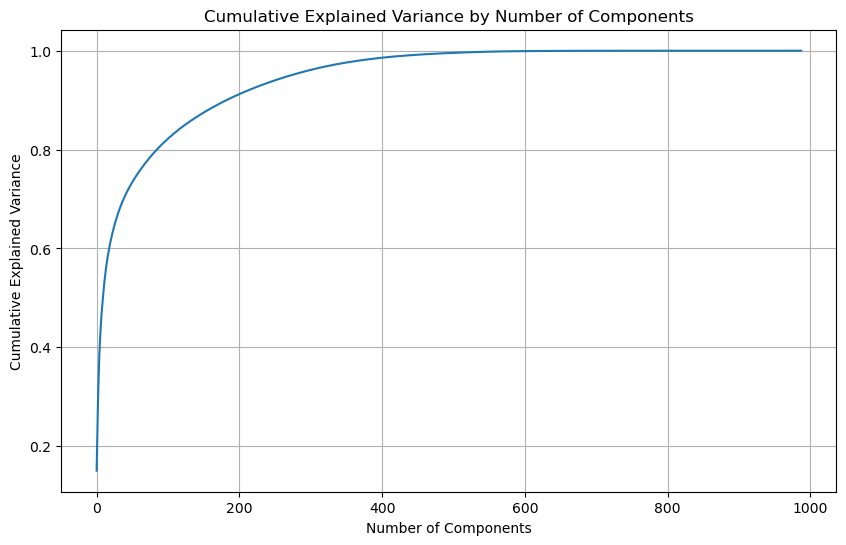

In [26]:
pca = PCA()
pca.fit(X_train_scaled)

# Plot cumulative explained variance
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance by Number of Components')
plt.grid(True)
plt.show()

In [27]:
pca = PCA(n_components=500)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Convert the PCA arrays back to DataFrames
X_train_pca = pd.DataFrame(data=X_train_pca, columns=[f'PC{i}' for i in range(1, 500 + 1)])
X_test_pca = pd.DataFrame(data=X_test_pca, columns=[f'PC{i}' for i in range(1, 500 + 1)])

In [28]:
lda = LinearDiscriminantAnalysis(n_components=4)
X_train_lda = lda.fit_transform(X_train_scaled, y_train)
X_test_lda = lda.transform(X_test_scaled)

# Convert the LDA arrays back to DataFrames
X_train_lda = pd.DataFrame(data=X_train_lda, columns=[f'LD{i}' for i in range(1, 5)])
X_test_lda = pd.DataFrame(data=X_test_lda, columns=[f'LD{i}' for i in range(1, 5)])

In [29]:
X_train_pca.to_csv("../data/processed/X_train_pca.csv", index=False)
X_test_pca.to_csv("../data/processed/X_test_pca.csv", index=False)

X_train_lda.to_csv("../data/processed/X_train_lda.csv", index=False)
X_test_lda.to_csv("../data/processed/X_test_lda.csv", index=False)